In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import collections
import gc
import time
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
import seaborn as sns
from mpl_toolkits import mplot3d

<h2> 1000-State Random Walk </h2><br/>
<b>Problem Credit:</b> Sutton & Barto, 2018 <br/><br/>
Consider a 1000-state version of the random walk where all states are numbered from 1 to 1000, left to right, and all episodes begin in state 500. The agent can transition from its current state to either one of the 100 immediate left states, or 100 immediate right states, with equal probability. If the current state is near an edge, then there may be fewer than 100 neighbors in which case all  probability for those missing neighbors goes into the probability of terminating on that side (thus, state 1 has a 0.5 probability of left termination and state 950 has a 0.25 probability of right termination). Left termination yields a -1 reward, and a right termination yields a +1 reward.

<b> STEP 1: Dynamic Programming Ground Truth </b><br/><br/>
We first use dynamic programming to establish ground-truth in the problem, before proceeding to evaluate function approximation approaches in their error. 

In [2]:
start = time.time()
error = 1e-3
v0 = np.zeros(1000, dtype=np.float64)
v1 = v0.copy()
actions = np.arange(200, dtype=np.int64)
actions[actions<100]-=100
actions[actions>=100]-=99
breaker = False
while (not breaker):
    for i in range(1000):
        totalvalue = 0
        for j in actions:
            newstate = (i+1)+j
            if (newstate<1) or (newstate>1000):
                totalvalue+=1 if newstate>1000 else -1
            else:
                totalvalue+=v0[newstate-1]
        v1[i] = totalvalue/200
    if np.max(np.abs(v0-v1))<error:
        breaker=True
    else:
        np.copyto(v0,v1)
print("Ground Truth Established in "+str(time.time()-start)+" seconds")

Ground Truth Established in 14.434396743774414 seconds


<b> STEP 2: Semi-Gradient TD with Artificial Neural Network </b><br/><br/>
We use semi-gradient TD with neural networks, and tilings to learn the value function of the uniform random policy, and compare it to the dynamic programming ground-truth. Using stochastic gradient descent, state-value prediction updates with TD are:

$$\mathbf{w_{t+1}} = \mathbf{w_{t}} + \alpha \delta_t \nabla \hat{v}(S_t,\mathbf{w_{t}})$$

The direction of weight update at each time step is $g_t = \delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$ using a fixed step-size $\alpha$. $\delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}}) - \hat{v}(S_t,\mathbf{w_t})$ is the TD-error. $\nabla \hat{v}(S_t,\mathbf{w_{t}})$ is the gradient of the value function with respect to the weights. To leverage existing Tensorflow architecture, we can use a bootstrapped design with mean-squared error loss metric on a dense ANN, with the truth label being $R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}})$ and the predicted label is, by design, $\hat{v}(S_t,\mathbf{w_t})$.

In [3]:
def get_move(curstate):
    action = np.random.choice(200)
    action -=100 if action<100 else 99
    newstate = curstate + action
    return (0,-1) if newstate<1 else (1001,1) if newstate>1000 else (newstate,0)

In [4]:
tf.keras.backend.clear_session()
inp = Input((1,))
data = Embedding(1000, 1000, weights=[np.eye(1000)], trainable=False)(inp)
data = Flatten()(data)
data = Dense(100, activation="relu", kernel_initializer="glorot_uniform", 
             bias_initializer="glorot_normal")(data)
data = Dense(1, activation=None, kernel_initializer="glorot_uniform", 
             bias_initializer="glorot_normal")(data)
valmodel = Model(inputs=inp, outputs=data)
valmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())
valmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1000)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,100,201
Trainable params: 100,201
Non-trainable params: 1,000,000
_________________________________________________________________


In [5]:
iterations = 10000
start = time.time()
traininglst = collections.deque()
for i in range(iterations):
    state = 500
    while ((state!=0) and (state!=1001)):
        newstate, reward = get_move(state)
        traininglst.append((state, newstate, reward))
        state = newstate
traininglst = np.array(traininglst)
startindex = 0
rmse = collections.deque()
while startindex<traininglst.shape[0]:
    data = traininglst[startindex:startindex+32,]
    mask = (data[:,1]==0)|(data[:,1]==1001)
    data[:,1][mask] = 1
    y = valmodel.predict(data[:,1]-1)[:,0]
    y[mask] = 0
    valmodel.fit(data[:,0]-1, data[:,2]+y, verbose=False, batch_size=32)
    startindex+=32
    rmse.append((np.sqrt(np.mean((valmodel.predict(np.arange(1000))[:,0]-v1)**2)), startindex))
print("Process Elapsed in "+str(time.time()-start)+" seconds")

Process Elapsed in 1890.6263699531555 seconds


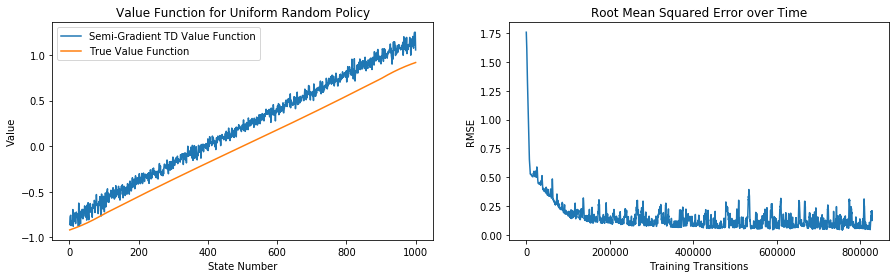

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(valmodel.predict(np.arange(1000))[:,0], index=np.arange(1000)+1).plot(
    label="Semi-Gradient TD Value Function")
pd.Series(v1, index=np.arange(1000)+1).plot(label="True Value Function")
plt.title("Value Function for Uniform Random Policy")
plt.xlabel("State Number")
plt.ylabel("Value")
plt.legend(loc="best")
plt.subplot(1,2,2)
plt.plot(np.array(rmse)[:,1], np.array(rmse)[:,0])
plt.xlabel("Training Transitions")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error over Time")
plt.show()

<b> STEP 3: Monte-Carlo Gradient Descent with Tiling </b><br/><br/>
We use 10 separate tilings, each of which divide the overall input space into maximum chunks of 200, offset from state 1. Hence, each tiling has 6 sections (accounting for offset), giving a 60-length feature vector for each state. We use linear methods to estimate the weight vector, using Monte Carlo updates.

In [30]:
def make_tilings(numtiles, division):
    tiles = np.full((numtiles, division+1), np.int(1000/division), dtype=np.int64)
    tiles[:,0] = np.random.choice(np.int(1000/division), numtiles, replace=False)+1
    tiles = np.cumsum(tiles, axis=1)
    tiles[:,-1] = 1000
    return tiles
def get_feature(tiles, curstate):
    allintervals = np.where(curstate<=tiles)
    uniq = np.unique(allintervals[0], return_index=True)[1]
    row, col = allintervals[0][uniq], allintervals[1][uniq]
    rep = np.zeros(tiles.shape[0]*tiles.shape[1])
    rep[row*tiles.shape[1]+col] = 1
    return rep

In [31]:
def mc_tile_experiment(numtiles, division, truth, iterations=10000, alpha=2e-4):
    start = time.time()
    tiles = make_tilings(numtiles, division)
    weight = np.zeros(numtiles*(division+1), dtype=np.float64)
    rmse = np.zeros(iterations, dtype=np.float64)
    values = np.zeros(1000, dtype=np.float64)
    for i in range(iterations):
        state = 500
        episodelst = collections.deque()
        while ((state!=0) and (state!=1001)):
            newstate, reward = get_move(state)
            episodelst.append(state)
            state = newstate
        for state in episodelst:
            feat = get_feature(tiles, state)
            weight+=alpha*(reward-np.sum(weight*feat))*feat
        for state in range(1000):
            values[state] = np.sum(get_feature(tiles, state+1)*weight)
        rmse[i] = np.sqrt(np.mean((values-truth)**2))
    print("Process Elapsed in "+str(time.time()-start)+" seconds")
    return weight, values, rmse

In [32]:
wh1, val1, rmse1 = mc_tile_experiment(10,5,v1)
wh2, val2, rmse2 = mc_tile_experiment(20,3,v1)

Process Elapsed in 273.69329810142517 seconds
Process Elapsed in 278.8486559391022 seconds


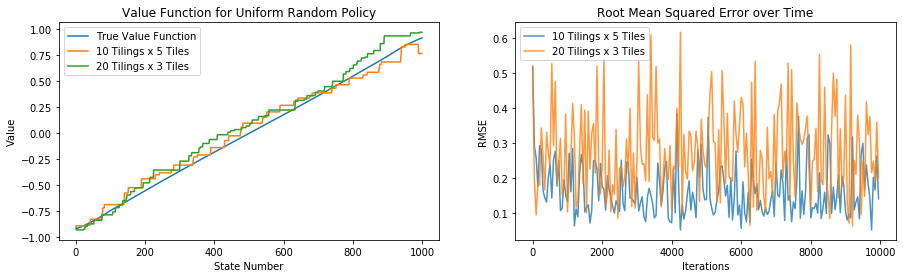

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(v1, index=np.arange(1000)+1).plot(label="True Value Function")
pd.Series(val1, index=np.arange(1000)+1).plot(label="10 Tilings x 5 Tiles")
pd.Series(val2, index=np.arange(1000)+1).plot(label="20 Tilings x 3 Tiles")
plt.xlabel("State Number")
plt.ylabel("Value")
plt.title("Value Function for Uniform Random Policy")
plt.legend(loc="best")
plt.subplot(1,2,2)
pd.Series(rmse1)[::50].plot(label="10 Tilings x 5 Tiles", alpha=0.8)
pd.Series(rmse2)[::50].plot(label="20 Tilings x 3 Tiles", alpha=0.8)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error over Time")
plt.legend(loc="best")
plt.show()

<h2> Mountain Car Continuous State Space </h2><br/>
<b>Problem Credit:</b> Alberta Machine Learning Institute <br/><br/>
We consider the continuous control task of driving a low-power car up a steep mountain, shown in the figure. Given a low power engine, the car cannot directly accelerate up the slope, but must rather climb the left slope to gain enough inertia. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). To simplify the physics, the car's movement is determined only by position $x_t$ and velocity $\dot{x}_t$. These are updated as:<br/>
$x_{t+1} = bound[x_t + \dot{x}_{t+1}]$<br/>
$\dot{x}_{t+1} = bound[\dot{x}_t + 0.001A_t - 0.0025cos(3x_t)]$

where the bound enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and episode terminated. Each episode started from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.
<img src="Mountain-Car.png" style="height:200px">

In [2]:
def get_pos_vel(xt, dotxt, At):
    dotxt1 = max(min(dotxt + 0.001*At - 0.0025*np.cos(3*xt), 0.07), -0.07)
    xt1 = max(min(xt+dotxt1, 0.5), -1.2)
    return (xt1, 0) if xt1==-1.2 else (xt1, dotxt1)

<b> STEP 1: Linear Function Approximation with 2-D Tiling </b><br/><br/>
We use 8 tilings with 8 tiles each to cover position, and similarly for velocity. Thus, 64-length vector represents position and 64-length vector for velocity, giving a 128-length state vector. In addition, we stack the three actions together, to get a 384-length state-action representation. Since all values will be negative (as all rewards are negative), we can initialize all weights to 0 to encourage exploration.

In [3]:
def make_tilings(numtiles, division, leftlim, rightlim):
    tiles = np.full((numtiles, division+1), (rightlim-leftlim)/division, dtype=np.float64)
    tiles[:,0] = np.random.uniform(low=leftlim, high=leftlim+(rightlim-leftlim)/division, size=numtiles)
    tiles = np.cumsum(tiles, axis=1)
    tiles[:,-1] = rightlim
    return tiles
def get_feature(postiles, veltiles, xt, dotxt, At):
    rep = np.zeros(3*(postiles.shape[0]*postiles.shape[1]+veltiles.shape[0]*veltiles.shape[1]))
    offset = 0
    action = 0 if At==-1 else np.int(rep.shape[0]/3) if At==0 else np.int(2*rep.shape[0]/3)
    for value, tiles in [(xt, postiles), (dotxt, veltiles)]:
        allintervals = np.where(value<=tiles)
        uniq = np.unique(allintervals[0], return_index=True)[1]
        row, col = allintervals[0][uniq], allintervals[1][uniq]
        rep[action+offset+row*tiles.shape[1]+col] = 1
        offset+=tiles.shape[0]*tiles.shape[1]
    return rep

In [4]:
def get_action_values(postiles, veltiles, xt, dotxt, weight):
    stateact = collections.deque()
    for At in [-1,0,1]:
        val = get_feature(postiles, veltiles, xt, dotxt, At)
        stateact.append(np.sum(val*weight))
    return stateact

In [5]:
#Exploring-Starts Helpers
def get_exploring_starts_start(postiles, veltiles, weight):
    xt, dotxt = np.random.uniform(low=-1.2, high=0.5), np.random.uniform(low=-0.07, high=0.07)
    At = np.random.choice([-1,0,1])
    return xt, dotxt, At
def get_exploring_starts_action(postiles, veltiles, xt, dotxt, weight):
    stateact = get_action_values(postiles, veltiles, xt, dotxt, weight)
    maxacts = np.where(stateact==np.max(stateact))[0]-1
    return np.random.choice(maxacts)

In [6]:
#Epsilon-Greedy Helpers
def get_epsilon_greedy_start(postiles, veltiles, weight, epsilon):
    xt, dotxt = np.random.uniform(low=-0.6, high=-0.4), 0
    At = get_epsilon_greedy_action(postiles, veltiles, xt, dotxt, weight, epsilon)
    return xt, dotxt, At
def get_epsilon_greedy_action(postiles, veltiles, xt, dotxt, weight, epsilon):
    stateact = get_action_values(postiles, veltiles, xt, dotxt, weight)
    maxacts = np.where(stateact==np.max(stateact))[0]-1
    prob = np.random.uniform()
    if prob<=1-epsilon:
        return np.random.choice(maxacts)
    return np.random.choice([-1,0,1])

In [7]:
def one_episode_sarsa(postiles, veltiles, alpha, weight, startfunc, actfunc, **kwargs):
    xt, dotxt, At = startfunc(postiles, veltiles, weight, **kwargs)
    xt1, dotxt1 = get_pos_vel(xt, dotxt, At)
    length = 1
    while (xt1<0.5):
        At1 = actfunc(postiles, veltiles, xt1, dotxt1, weight, **kwargs)
        vect = get_feature(postiles, veltiles, xt, dotxt, At)
        vect1 = get_feature(postiles, veltiles, xt1, dotxt1, At1)
        weight+=alpha*(-1+np.sum(vect1*weight)-np.sum(vect*weight))*vect
        xt, dotxt, At = xt1, dotxt1, At1
        xt1, dotxt1 = get_pos_vel(xt, dotxt, At)
        length+=1
    vect = get_feature(postiles, veltiles, xt, dotxt, At)
    weight+=alpha*(-1-np.sum(vect*weight))*vect
    return weight, length

In [8]:
def sarsa_simulation(numtiles, division, alpha, iterations, startfunc, actfunc, **kwargs):
    postiles = make_tilings(numtiles, division, -1.2, 0.5) 
    veltiles = make_tilings(numtiles, division, -0.07, 0.07)
    weight = np.zeros((numtiles*(division+1))*6)
    eplength = np.zeros(iterations)
    for i in range(iterations):
        weight, eplength[i] = one_episode_sarsa(postiles, veltiles, alpha, weight, startfunc, actfunc, **kwargs)
    x = pd.DataFrame(index=np.arange(-1.2, 0.5, 0.01), columns=np.arange(-0.07, 0.07, 0.001))
    x = x.apply(lambda s: s.apply(lambda g: s.name))
    x = x.apply(lambda s: s.apply(lambda g: (s.name, g)), axis=1)
    x = x.applymap(lambda s: -np.max(get_action_values(postiles, veltiles, s[0], s[1], weight)))
    x = x.stack().reset_index().values
    return weight, x, eplength

Exploring Starts Ended in 89.40175199508667 seconds
Exploring Starts Ended in 98.6205141544342 seconds


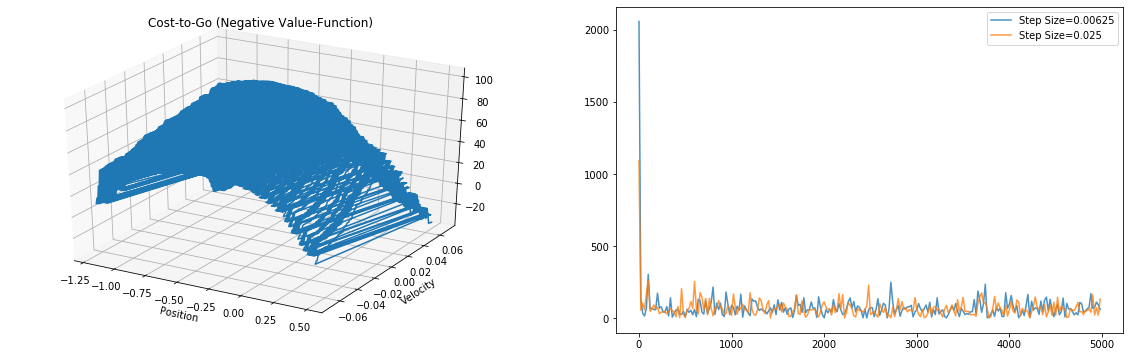

In [9]:
plt.figure(figsize=(20,6))
start = time.time()
weight, x, eplength = sarsa_simulation(8, 7, 0.05/8, 5000, get_exploring_starts_start, get_exploring_starts_action)
print("Exploring Starts Ended in "+str(time.time()-start)+" seconds")
ax = plt.subplot(1,2,1, projection='3d')
ax.plot3D(x[:,0], x[:,1], x[:,2])
plt.title("Cost-to-Go (Negative Value-Function)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.subplot(1,2,2)
start = time.time()
_, _, eplength2 = sarsa_simulation(8, 7, 0.2/8, 5000, get_exploring_starts_start, get_exploring_starts_action)
print("Exploring Starts Ended in "+str(time.time()-start)+" seconds")
pd.Series(eplength)[::20].plot(label="Step Size="+str(0.05/8), alpha=0.8)
pd.Series(eplength2)[::20].plot(label="Step Size="+str(0.2/8), alpha=0.8)
plt.legend(loc="best")
plt.show()

This Cost-to-Go function seems reasonable, primarily since having low velocity close to target position involves high cost-to-go since you must go up the left slope before going up the right slope again. Instead high velocity near target incurs low cost.

<h2>Continuous Priority Scheduling</h2><br/>
We simulate a continuous decision-making task to schedule tasks on a set of 10 servers. The priorities of the task correspond to rewards of 1,2, 4, or 8 if the task is accepted and its negative if rejected. The queue is infinite and all the priorities are randomly assigned. A task cannot be accepted if all servers are full, and there is a 0.06 probability that each used server gets freed in each time stamp. The objective is to maximize long-term reward without discounting, and thus we use differential semi-gradient SARSA with average reward. We avoid generalization (mimicking a tabular approach with function approximation for proof-of-concept). We define the average reward $r(\pi)$ and the resultant Bellman optimality differential equation:
$$r(\pi) = \lim_{t\to\infty}\mathbb{E}[R_t|S_0, A_{0:t-1} \sim \pi]$$
$$q_*(s,a) = \sum_{r,s'}p(r,s'|s,a)[r-max_\pi r(\pi)+max_{a'}q(s',a')]$$

In [110]:
def get_next_customer():
    return np.random.choice([1,2,4,8])
def get_embedding(priority, empserver, accept):
    emb = np.zeros(88)
    offset = 0 if accept==True else 44
    emb[offset+np.int(np.log2(priority))*11+empserver] = 1
    return emb
def get_next_server(empserver, probfree):
    probs = np.random.uniform(size=10-empserver)
    return empserver+np.sum(probs<probfree)

In [114]:
def get_epsilon_greedy_action(priority, empserver, weight, epsilon):
    if empserver<=0: return -1
    accpt = np.sum(get_embedding(priority, empserver, True)*weight)
    rejct = np.sum(get_embedding(priority, empserver, False)*weight)
    if accpt==rejct:
        return np.random.choice([1,-1])
    prob = np.random.uniform()
    if prob<=(1-epsilon):
        return 1 if accpt>rejct else -1
    else:
        return -1 if accpt>rejct else 1

In [121]:
def differential_SARSA_simulation(alpha, beta, iterations, probfree, epsilon):
    weight = np.zeros(88)
    avgrwd, runningrwd = 0, np.zeros(iterations)
    s1 = (get_next_customer(), 10)
    a1 = np.random.choice([-1,1])
    for i in range(iterations):
        newserver=get_next_server(s1[1], probfree)
        rwd = a1*s1[0]
        newserver-=1 if a1==1 else 0   
        s2 = (get_next_customer(), newserver)
        a2 = get_epsilon_greedy_action(s2[0], s2[1], weight, epsilon)
        feats2a2 = get_embedding(s2[0], s2[1], a2==1)
        feats1a1 = get_embedding(s1[0], s1[1], a1==1)
        delta = rwd-avgrwd+np.sum(feats2a2*weight)-np.sum(feats1a1*weight)
        avgrwd += beta*delta
        weight += alpha*delta*feats1a1
        s1, a1 = s2, a2
        runningrwd[i] = rwd
    return weight, runningrwd

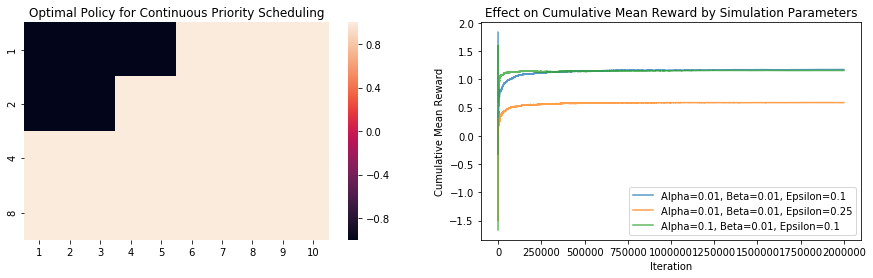

In [142]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
w1, r1 = differential_SARSA_simulation(0.01, 0.01, 2000000, 0.06, 0.1)
arr = np.zeros((4, 10))
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        accpt = np.sum(get_embedding(2**i, j+1, True)*w1)
        rejct = np.sum(get_embedding(2**i, j+1, False)*w1)
        arr[i,j] = 1 if accpt>=rejct else -1
sns.heatmap(arr, xticklabels=(np.arange(10)+1), yticklabels=[1,2,4,8])
plt.title("Optimal Policy for Continuous Priority Scheduling")
plt.subplot(1,2,2)
w2, r2 = differential_SARSA_simulation(0.01, 0.01, 2000000, 0.06, 0.25)
w3, r3 = differential_SARSA_simulation(0.1, 0.01, 2000000, 0.06, 0.1)
pd.Series(np.cumsum(r1)/(np.arange(2000000)+1))[5:].plot(label="Alpha=0.01, Beta=0.01, Epsilon=0.1", alpha=0.75)
pd.Series(np.cumsum(r2)/(np.arange(2000000)+1))[5:].plot(label="Alpha=0.01, Beta=0.01, Epsilon=0.25", alpha=0.75)
pd.Series(np.cumsum(r3)/(np.arange(2000000)+1))[5:].plot(label="Alpha=0.1, Beta=0.01, Epsilon=0.1", alpha=0.75)
plt.title("Effect on Cumulative Mean Reward by Simulation Parameters")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Mean Reward")
plt.legend(loc="best")
plt.show()